## Lab 3 - Code & Comments
Elysa Strunin  
October 2018  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import datasets, linear_model

import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy import stats

/Users/estrunin/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### 1. Data Preparation and Feature Construction

#### Data: Melanoma Incidence Rates

In [2]:
# Melanoma incidence rate data

# Data source: County level cancer incidence rate data from the State Cancer Profiles resource jointly 
# developed by the NCI and the CDC. Dataset of the incidence rate of melanoma 
# for the most recent five years of the available data. 

melanoma = pd.read_table('melanomav08.txt', na_values='*', skipinitialspace=False) #, header=None)

melanoma.columns = ['County', 'FIPS', 'Incidence_Rate',
       'Lower_95%_CI', 'Upper_95%_CI',
       'Average_Annual_Count', 'Recent_Trend',
       'Recent_5-Year_Trend_Incidence_Rates',
       'Lower_95%_CI', 'Upper_95%_CI']

melanoma = melanoma[melanoma['Incidence_Rate'] != '* ']

melanoma.head()

,County,FIPS,Incidence_Rate,Lower_95%_CI,Upper_95%_CI,Average_Annual_Count,Recent_Trend,Recent_5-Year_Trend_Incidence_Rates,Lower_95%_CI,Upper_95%_CI
0,"US (SEER+NPCR)(1,10)",0,20.7,20.6,20.8,71035,rising,1.8,1,2.6
1,"Lexington City, Virginia(6,10)",51678,85,48.7,137.1,4,stable,14.8,-32.8,96.3
2,"Beaver County, Utah(7)",49001,80.8,52.4,119,5,NaN,NaN,NaN,NaN
3,"Summit County, Utah(7,8)",49043,74.3,61,89.7,27,rising,7.6,5.1,10.2
4,"Nantucket County, Massachusetts(6,10)",25019,65.3,45.7,90.8,7,stable,-16.3,-48.8,36.8


#### Data: Median Income Levels

In [3]:
# Median income level data

# Median income level for all counties from:
# https://statecancerprofiles.cancer.gov/demographics/index.php
# "All Ages, All Races, Both Sexes"
# 2012-2016 American Community Survey 5-Year Data

income = pd.read_csv('census.csv', skiprows=5)
income = income.iloc[1:3141,:]
income.columns = ['County', 'FIPS', 'Value_Dollars', 'Rank']

income.FIPS = income.FIPS.astype(int)
income.head()

,County,FIPS,Value_Dollars,Rank
1,"Stewart County, Georgia",13259,22500.000000000,"3,137"
2,"McCreary County, Kentucky",21147,24063.000000000,"3,136"
3,"Holmes County, Mississippi",28051,25247.000000000,"3,135"
4,"Shannon County, South Dakota",46113,26364.000000000,"3,134"
5,"Issaquena County, Mississippi",28055,26667.000000000,"3,133"


#### Data: Average Daily Sunlight

In [4]:
# Average sunlight data 

# Note: I selected the "aggregate" date of year 2000, and the full range (KJ/m^2) for sunlight

sunlight = pd.read_table('sunlight.txt', header=None, encoding = "ISO-8859-1") #, skiprows=2, header=None
sunlight = sunlight.iloc[:3111,1:]
sunlight.columns = ['County', 'FIPS', 'Avg_Daily_Sunlight']

sunlight.FIPS = sunlight.FIPS.astype(int)
sunlight.head()

,County,FIPS,Avg_Daily_Sunlight
0,"Autauga County, AL",1001,18125.260491
1,"Baldwin County, AL",1003,18724.764125
2,"Barbour County, AL",1005,18287.261284
3,"Bibb County, AL",1007,17938.818688
4,"Blount County, AL",1009,17114.548989


#### Data: Education (Extra Feature)

In [5]:
# Extra feature for later: 

# Education data from the same source as the income data
# Lower_Education indicates the percentage of people with less than a ninth grade education

education = pd.read_csv('education.csv', skiprows=6)
education = education.iloc[:3141,:]
education.columns = ['County', 'FIPS', 'Lower_Education', 'People', 'Rank']
del education['County']
del education['People']
del education['Rank']
education = education.dropna()

education.FIPS = education.FIPS.astype(int)
education.head()

,FIPS,Lower_Education
0,0,5.6
1,39075,34.6
2,48427,34.0
3,48377,31.7
4,48505,30.9


#### Aggregating the Data

In [6]:
# Merge the data sets and extract the relevant columns

data = melanoma.merge(income, on='FIPS', how='left', sort=False)
data = data.merge(sunlight, on='FIPS', how='left', sort=False)
data = data.merge(education, on='FIPS', how='left', sort=False)

segment = data[[ 'Incidence_Rate', 'Value_Dollars', 'Avg_Daily_Sunlight', 'Lower_Education']]
segment.index = data['FIPS']
segment = segment.dropna()

#### Data: Neighboring Incidence Rates (Extra Feature)

In [7]:
# Extra feature:

# Predict incidence level of melanoma from the incidence rates of neighboring counties
# County adjacency file: https://www.census.gov/geo/reference/county-adjacency.html (unwieldy formatting)

adj = pd.read_table('county_adjacency.txt', header=None, encoding = "ISO-8859-1") 
adj.columns = ['County', 'FIPS_Own', 'Neighbor', 'FIPS'] # here, second FIPS is neighbor FIPS
adj = adj.merge(segment, on='FIPS', how='left', sort=False)
del adj['Value_Dollars']
del adj['Avg_Daily_Sunlight']
del adj['Lower_Education']

adj.head(10)

,County,FIPS_Own,Neighbor,FIPS,Incidence_Rate
0,"Autauga County, AL",1001.0,"Autauga County, AL",1001,24.5
1,NaN,NaN,"Chilton County, AL",1021,21.6
2,NaN,NaN,"Dallas County, AL",1047,11.2
3,NaN,NaN,"Elmore County, AL",1051,30.3
4,NaN,NaN,"Lowndes County, AL",1085,NaN
5,NaN,NaN,"Montgomery County, AL",1101,18.3
6,"Baldwin County, AL",1003.0,"Baldwin County, AL",1003,30.1
7,NaN,NaN,"Clarke County, AL",1025,22
8,NaN,NaN,"Escambia County, AL",1053,16.1
9,NaN,NaN,"Mobile County, AL",1097,21.6


In [8]:
#Create a dataframe that's easier to use

vec = adj.copy().iloc[:,1]

#init
filter0 = 1

while np.sum(filter0) > 0:
    
    vec_shift = np.asarray(vec.copy())
    vec_shift = vec_shift.tolist()
    vec_shift.insert(len(vec),np.nan)
    vec_shift = pd.Series(vec_shift[1:])
    
    new =  vec.copy()
    new = new.replace(np.nan, 0)
    
    tf = pd.notnull(vec)
    tf.head()
    
    ft = pd.isnull(vec_shift)
    
    filter_ = tf & ft
    filter_ = filter_ * vec
    filter0 = np.asarray(filter_.copy())
    filter0 = filter0.tolist()
    filter0.insert(0,0)
    filter0 = pd.Series(filter0[:-1])
    filter0 = filter0.replace(np.nan, 0)
    new = new + filter0

    new = new.replace(0, np.nan)

    vec = new

In [9]:
# Nicer dataframe

adj['FIPS_Own'] = new
adj.FIPS_Own = adj.FIPS_Own.astype(int)
adj = adj[adj['FIPS_Own'] != adj['FIPS']] # remove the repetitive row
adj.head()

,County,FIPS_Own,Neighbor,FIPS,Incidence_Rate
1,NaN,1001,"Chilton County, AL",1021,21.6
2,NaN,1001,"Dallas County, AL",1047,11.2
3,NaN,1001,"Elmore County, AL",1051,30.3
4,NaN,1001,"Lowndes County, AL",1085,NaN
5,NaN,1001,"Montgomery County, AL",1101,18.3


#### Aggregating the Data

In [11]:
# Finally, place all of the data in one dataframe

adj.Incidence_Rate = adj.Incidence_Rate.astype(float)

groupby = adj['Incidence_Rate'].groupby(adj['FIPS_Own'])

means = groupby.describe()['mean']
means_df = pd.DataFrame({'Rate_Neighbor': means, 'FIPS': means.index})
means_df.head()

data = segment.merge(means_df, on='FIPS', how='left', sort=False)
data = data.dropna()

data.Incidence_Rate = data.Incidence_Rate.astype(float)
data.Value_Dollars = data.Value_Dollars.astype(float)

# scale the data so it's all a little more proportional / easily interpretable
data['Value_Dollars'] = data['Value_Dollars']/1000
data['Avg_Daily_Sunlight'] = data['Avg_Daily_Sunlight']/1000

data.head()

,FIPS,Incidence_Rate,Value_Dollars,Avg_Daily_Sunlight,Lower_Education,Rate_Neighbor
0,51678,85.0,67.457,15.829576,8.1,33.700000
1,49001,80.8,57.643,17.882766,1.7,36.400000
2,49043,74.3,103.350,17.292476,3.1,35.283333
3,25019,65.3,109.863,15.610617,0.9,44.900000
4,13281,60.9,48.717,16.640618,5.0,34.280000


#### Pairwise Analysis

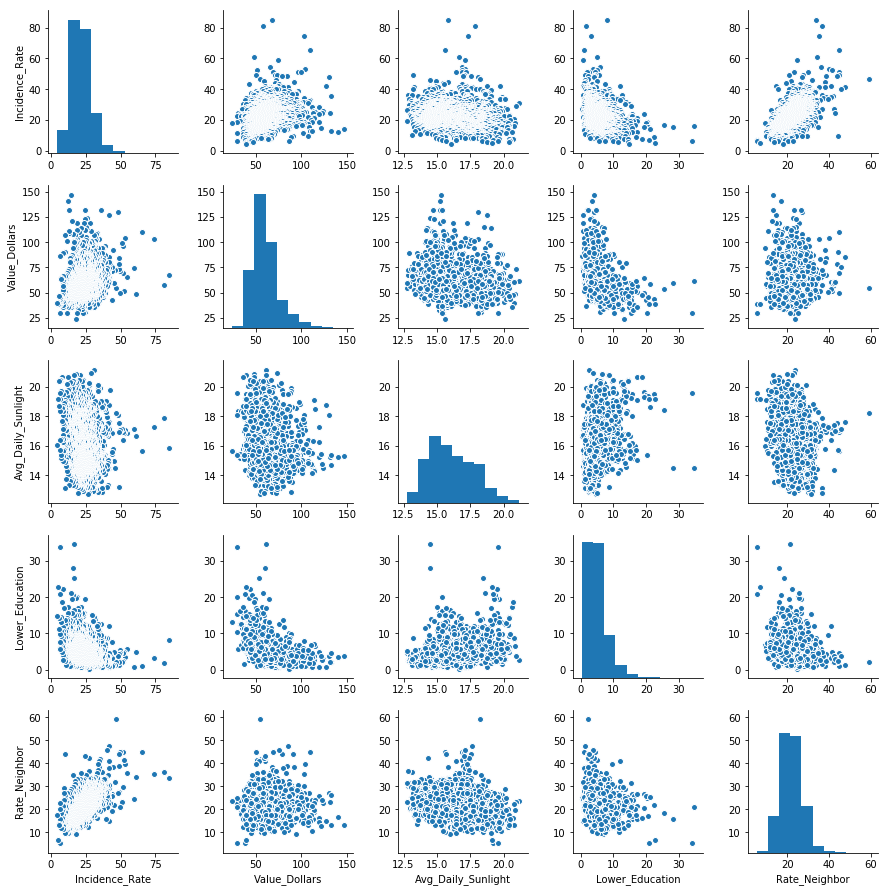

In [12]:
# Visualize each of the relationships

# Unfortunately, not seeing super strong correlation with Incidence Rate, aside from the Neighboring Rates feature

sns.pairplot(data[['Incidence_Rate', 'Value_Dollars', 'Avg_Daily_Sunlight', 'Lower_Education', 'Rate_Neighbor']])
plt.show()

### 2. Model Construction 

In [13]:
# Specify features and target
rate = data[['Incidence_Rate']]
features = data[['Value_Dollars', 'Avg_Daily_Sunlight']]

# For context, and to support the visualization, here are correlations with rate
# Perhaps unsurprisingly, correlation with neighboring rates is the strongest

print('Correlation:')
print('Incidence Rate, Median Income:', data['Incidence_Rate'].corr( features['Value_Dollars'] ) )
print('Incidence Rate, Average Daily Sunlight:', data['Incidence_Rate'].corr( features['Avg_Daily_Sunlight'] ) )
print('Incidence Rate, Lower Education:', data['Incidence_Rate'].corr( data['Lower_Education'] ) )
print('Incidence Rate, Neighboring Rates:', data['Incidence_Rate'].corr( data['Rate_Neighbor'] ) )

Correlation:
Incidence Rate, Median Income: 0.27588415288491275
Incidence Rate, Average Daily Sunlight: -0.13148337132969826
Incidence Rate, Lower Education: -0.262086343010013
Incidence Rate, Neighboring Rates: 0.6158128985823065


#### Linear Regression: Incidence Rates on Incomes, Sunlight

In [14]:
# Perform linear regression

X = sm.add_constant(features)
X = np.asarray(X)
rate = np.ravel(rate)
fit = sm.OLS(rate, X ).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     90.29
Date:                Thu, 04 Oct 2018   Prob (F-statistic):           2.78e-38
Time:                        23:15:17   Log-Likelihood:                -6892.4
No. Observations:                2022   AIC:                         1.379e+04
Df Residuals:                    2019   BIC:                         1.381e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.8407      1.875     10.584      0.0

#### Linear Regression: Incidence Rates on Incomes, Sunlight, Education

In [15]:
rate = data[['Incidence_Rate']]
features = data[['Value_Dollars', 'Avg_Daily_Sunlight', 'Lower_Education']]

X = sm.add_constant(features)
X = np.asarray(X)
fit = sm.OLS(rate, X ).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:         Incidence_Rate   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     76.68
Date:                Thu, 04 Oct 2018   Prob (F-statistic):           5.75e-47
Time:                        23:15:21   Log-Likelihood:                -6869.9
No. Observations:                2022   AIC:                         1.375e+04
Df Residuals:                    2018   BIC:                         1.377e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.3281      1.856     10.954      0.0

#### Linear Regression: Incidence Rates on Incomes, Sunlight, Education, Neighboring Rates

In [16]:
rate = data[['Incidence_Rate']]
features = data[['Value_Dollars', 'Avg_Daily_Sunlight', 'Lower_Education', 'Rate_Neighbor']]

X = sm.add_constant(features)
X = np.asarray(X)
fit = sm.OLS(rate, X ).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:         Incidence_Rate   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     377.6
Date:                Thu, 04 Oct 2018   Prob (F-statistic):          6.84e-243
Time:                        23:15:24   Log-Likelihood:                -6413.9
No. Observations:                2022   AIC:                         1.284e+04
Df Residuals:                    2017   BIC:                         1.287e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8911      1.658     -2.950      0.0

### 3. Model Evaluation *(same text as part 3 of write-up)*

Overall, the models have poor predictive power. However, adding the extra features improves R-squared considerably, without sacrificing significance of coefficients.
1.  Features: income, sunlight  
R-squared is 0.082 (dismal)  
P-values on coefficients are significant at < 5% level (heartening)  
Directionalities of both coefficients (positive income, negative sunlight) are unexpected: perhaps the income coefficient reflects the phenomenon of sunny locations attracting wealthy populations
Including the sunlight variable is an attempt at controlling for this, though

2.  Features: income, sunlight, education  
R-squared is 0.102 (slight improvement)  
P-values on income and education coefficients are significant at < 5% level (heartening); p-value on sunlight becomes insignificant (perhaps related to counterintuitive directionality)  
Directionality of income coefficient remains the same; (lack of) education coefficient is negative, which is unexpected. Might be reflecting the same phenomena as income coefficient  
Correlation between income and sunlight is -0.2, which refutes the sunny/wealthy hypothesis. Perhaps this analysis needs to be subsetted into large regions of the country, or rural/urban regions, which behave differently...
	
3.  Features: income, sunlight, education, neighboring incidence rates   
R-squared is 0.428 (notable improvement)  
All p-values are significant at < 5% level (heartening)  
Directionality of income and education coefficients remain the same, perhaps indicating a robustness across feature combinations; (lack of) education coefficient switches signs. Mean neighboring rate coefficient is positive (heartening)

Additional Points  
- The large improvement in predictive power associated with the mean neighboring rate feature was heartening, although unsurprising. Its contribution indicates that perhaps this type of model is better suited for one-off interpolation than prediction of all county melanoma rates.  
- The consistent positive income coefficient is baffling. In the future, I’d search for more of an explanation.  
- Via NA’s, there were a lot of dropped rows along the way (roughly a third of the original data). If it made sense conceptually, I’d try to select the timeframes for which there are fewer NA’s.

